# **Advanced Data Science for Innovation**

## Asignment 1: NBA Career Prediction - Predict 5-Year Longevity for NBA Rookies

**Student Name:** Sean Williams

**Student No. :** ??

**Week:** 4

**Date:** 06MAR2022

**Team Name:** Group 1
* Carol Myhill - 90014679
* Nathan Fragar - 93087548
* Nuwan Munasinghe - 13104409
* Sean Williams - ??
* Wenying Wu - 14007025

## 1. Load Python packages and libraries

**[1.1]** Task: Change working directory to enable importing of Python modules

In [1]:
cd /home/jovyan/work

/home/jovyan/work


In [2]:
# pip install xgboost

**[1.2]** Task: Import required packages

In [3]:
# Data manipulation and Utility modules
import pandas as pd
import numpy as np
import joblib as job

# Learning Model
import xgboost as xgb

# Model Optimising
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

# Custom Functions
from src.data.sets import load_sets
from src.models.null import NullModel
from src.models.performance import score_null_model
from src.models.performance import score_models2
from src.visualization.visualize import plot_confusion_matrix_full
from src.visualization.visualize import plot_roc_auc

**[1.3]** Task: Automatically Reload Modules

In [4]:
# Automatically reload modules
%load_ext autoreload
%autoreload 2

**[1.4]** Task: Load Processed Datasets

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = load_sets(path='data/processed/', val=False)

**[1.5]** Task: Verify number of observations in Processed Datasets

In [6]:
X_train.shape, y_train.shape,  X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5120, 42), (5120,), (1280, 42), (1280,), (1600, 42), (1600,))

## 2. Create Baseline Model

**[2.1]** Task: Instantiate a Null Model class for a classification problem

In [7]:
base_model = NullModel(target_type="classification")

**[2.2]** Task: Fit and make predictions on the data set

In [8]:
y_base = base_model.fit_predict(y_train)

**[2.3]** Task: Print the base model's performance metrics

In [9]:
score_null_model(y_train = y_train, y_base = y_base, set_name="Base")

,Set Name,ACC,MSE,MAE,PREC,RECALL,F1,AUC
0,Base,0.833594,0.407929,0.166406,1.0,0.833594,0.909246,None


## 3. Modelling - XGBoost - Hyperparameter Tuning with Random Search and KFold Cross Validation

**[3.1]** Task: Build list of Hyperparameters to be tuned

In [10]:
learning_rate = [0.01, 0.05, 0.1, 0.5]
n_estimators = [100, 500, 1000]
subsample = [0.5, 0.7, 0.8]
colsample_bytree = [0.5, 0.7, 0.8]
max_depth = [3, 7, 9]
min_child_weight = [1, 5, 10]

In [11]:
# Build dictionary for grid search
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, colsample_bytree=colsample_bytree, max_depth=max_depth, min_child_weight=min_child_weight)

In [12]:
# Setup cross validation folds
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

**[3.2]** Task: Build randomsearch with specified parameters and K-Folds

In [13]:
# Instantiate XGBoost class with default parameters
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', gamma=0, scale_pos_weight=1)

In [14]:
# Random search with cross validation
random_search = RandomizedSearchCV(clf, param_grid, scoring="accuracy", cv=kfold, n_jobs=4,  n_iter=500, random_state=8)

**[3.3]** Task: Train Model and print best result and parameters

In [15]:
#Fit to data
random_result = random_search.fit(X_train, y_train)
# Print best score and parameters
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

In [16]:
# Get the best model from the random search and fit to data
clf_best_random = xgb.XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, use_label_encoder=False, eval_metric='logloss').fit(X_train, y_train)

In [17]:
job.dump(clf_best_random, "models/Group1-Assignment1-XGBoost.joblib", compress=3)

['models/Group1-Assignment1-XGBoost.joblib']

**[3.5]** Task: Print the best XGBoost model's performance metrics

In [18]:
# Print Scores for all Data Sets
score_models2(X_train, y_train, X_val, y_val, X_test, y_test, y_base, True, clf_best_random)

,Set Name,ACC,MSE,MAE,PREC,RECALL,F1,AUC
0,Base,0.833594,0.407929,0.166406,1.000000,0.833594,0.909246,NaN
1,Train,0.839453,0.400683,0.160547,0.839307,0.998594,0.912048,0.775197
2,Validate,0.839063,0.401170,0.160938,0.838710,0.999063,0.911891,0.711912
3,Test,0.835000,0.406202,0.165000,0.836478,0.997001,0.909713,0.681835


**[3.6]** Task: Plot the confusion matrix for the Train and Test datasets

Train - Confusion matrix, without normalization
[[  36  816]
 [   6 4262]]
Train - Normalized confusion matrix
[[0.04225352 0.95774648]
 [0.00140581 0.99859419]]
Validate - Confusion matrix, without normalization
[[   6  260]
 [   4 1330]]
Validate - Normalized confusion matrix
[[0.02255639 0.97744361]
 [0.0029985  0.9970015 ]]


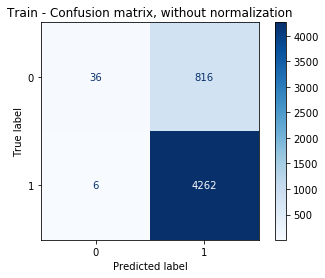

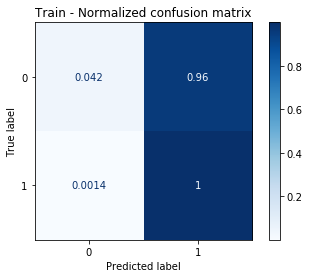

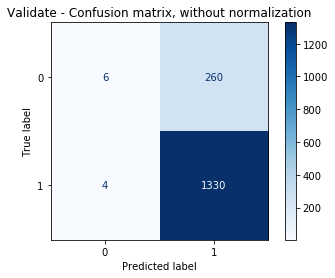

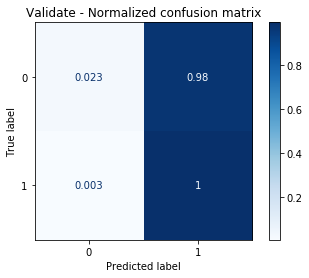

In [19]:
plot_confusion_matrix_full(model=clf_best_random, X_train = X_train, y_train = y_train, X_val = X_test, y_val = y_test)

**[3.5]** Task: Visualise AUC Metric

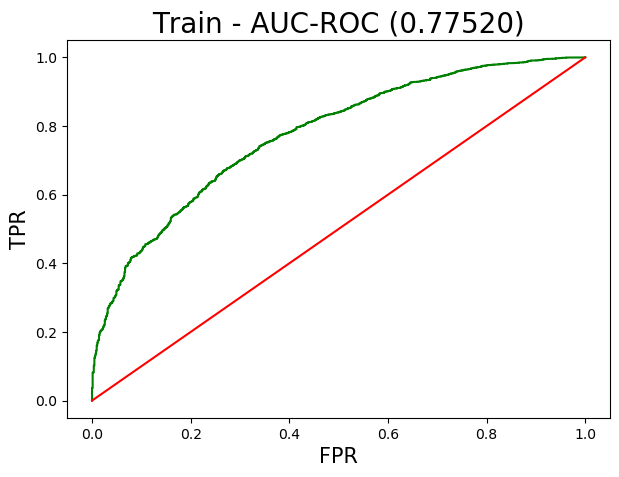

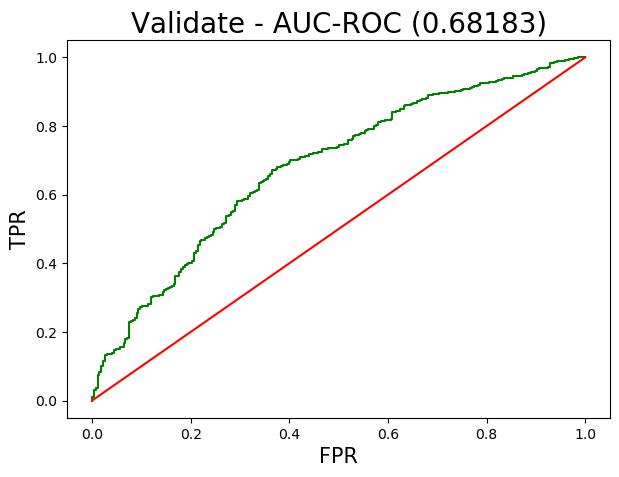

In [20]:
plot_roc_auc(X_train = X_train, y_train = y_train, X_val = X_test, y_val = y_test, model = clf_best_random)

## 4. Kaggle Submission - XGBoost

**[4.1]** Task: Load processed datasets

In [21]:
X_kaggle = pd.read_csv('data/processed/test.csv').to_numpy()
Id_kaggle = pd.read_csv('data/raw/test.csv')

**[4.2]** Task: Verify number of observations in Processed Datasets

In [22]:
X_kaggle.shape, Id_kaggle.shape

((3799, 42), (3799, 20))

**[4.3]** Generate Predictions on the processed dataset using using the best XGBoost Model

In [23]:
kaggle_probs = clf_best_random.predict_proba(X_kaggle)[:, 1]

**[4.3]** Construct a dataframe in the format required for the submission

In [24]:
df_kaggle = pd.DataFrame({'Id':Id_kaggle['Id'], 'TARGET_5Yrs': kaggle_probs});

**[4.4]** Task: Verify number of observations and columns in submission dataset

In [25]:
df_kaggle.shape

(3799, 2)

**[4.5]** Task: Write the dataframe to a csv file

In [26]:
df_kaggle.to_csv("data/external/Group1_Assignment1_XGBoost_predictions.csv", index=False)